In [1]:
%matplotlib inline

In [15]:
import pandas as pd
import numpy as np
import re
import dateparser


In [3]:
df = pd.read_csv("./cada-2018-09-25.csv")

In [4]:
df

,Numéro de dossier,Administration,Type,Année,Séance,Objet,Thème et sous thème,Mots clés,Sens et motivation,Partie,Avis
0,19840002,ministre de la défense,Avis,1984,03/03/1984,[Voir avis],"Justice, Ordre Public Et Sécurité/Défense Et D...",Armée,Défavorable/Défense,III,La commission d'accès aux documents administra...
1,19840003,ministre de la défense,Avis,1984,13/12/1984,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Armée,"Irrecevable/Imprécise, Défavorable/Défense, In...",III,La commission d'accès aux documents administra...
2,19850001,"ministre de l'économie, des finances et du budget",Avis,1985,05/12/1985,[Voir avis],"Justice, Ordre Public Et Sécurité/Association,...",NaN,Défavorable,III,La commission d'accès aux documents administra...
3,19860001,directeur départemental du travail et de l'emp...,Conseil,1986,30/01/1986,(voir avis),Travail Et Emploi/Droit Du Travail,"Licenciement, Conditions de travail","Défavorable/Procédure, Sans objet",III,La commission d'accès aux documents administra...
4,19870061,gouverneur de la Banque de France,Avis,1987,02/04/1987,[Voir avis],"Economie, Industrie, Agriculture/Secteurs Écon...",Banques et assurances,"Défavorable/Sécurité publique, Favorable/Sauf ...",III,La commission d'accès aux documents administra...
5,19870380,directeur de la caisse régionale d'assurance m...,Avis,1987,30/04/1987,[Voir avis],Affaires Sanitaires Et Sociales/Solidarités Et...,"Sécurité sociale, Conditions de travail",Défavorable/Secret,III,La commission d'accès aux documents administra...
6,19881774,directeur général des impôts,Avis,1988,24/11/1988,(voir avis),Finances Publiques Et Fiscalité/Contrôle Fisca...,NaN,Défavorable/Procédure,III,La commission d'accès aux documents administra...
7,19881993,ministre de l'intérieur,Avis,1988,22/12/1988,[Voir avis],"Justice, Ordre Public Et Sécurité/Sécurité Civ...",Politique et réglementation,"Défavorable/Abusive, Sans objet",III,La commission d'accès aux documents administra...
8,19890099,ministre de l'intérieur (direction de la logis...,Avis,1989,19/01/1989,"- instructions, circulaires et guides opérateu...","Justice, Ordre Public Et Sécurité/Sécurité Civ...",Politique et réglementation,Favorable,III,La commission d'accès aux documents administra...
9,19890845,ministre de la justice (direction de l'adminis...,Conseil,1989,18/05/1989,"- ""tableau de service"" du centre de détention ...","Travail Et Emploi/Emploi Public, Justice, Ordr...","Carrière, Lieux de détention",Défavorable/Sécurité publique,II,La commission d'accès aux documents administra...


In [5]:
df["Sens_reduced"] = df["Sens et motivation"].dropna().apply(lambda x: re.split("[/,]+", x)[0].strip())
df.Année = pd.to_numeric(df.Année)


## Stat Descriptive

### Distribution of the types of answers

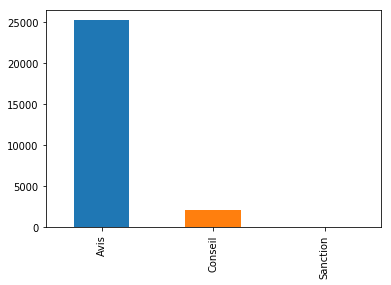

In [6]:
df.Type.value_counts().plot(kind="bar")
#print()
#print(df.Administration.value_counts())

### Distribution of the types of senses 
* TODO: Distribution of motivations ...

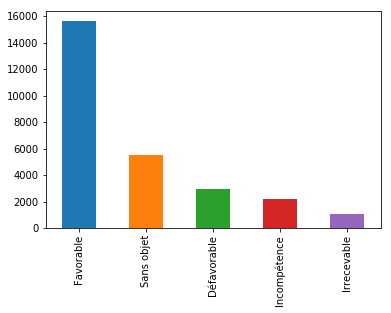

In [7]:
df.Sens_reduced.replace('', np.nan, inplace=True)
df.Sens_reduced.value_counts().plot(kind="bar")

### Distribution of petitions by year

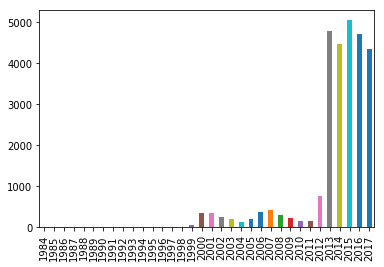

In [8]:
#df.Année.value_counts().plot(kind="bar")
df.Année.value_counts().sort_index().plot(kind="bar")


### All petitions per administration
* Most of them only receive one or two petitions from CADA
  

count    10672.000000
mean         2.567185
std         12.719201
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        885.000000
Name: Administration, dtype: float64


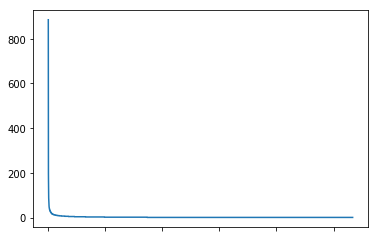

In [9]:
admin = df.Administration.dropna().value_counts()
admin.plot()
# Most administrations requested by the CADA receive only one or two petitions
print(admin.describe())

### Administrations with more than 50 CADA petitions

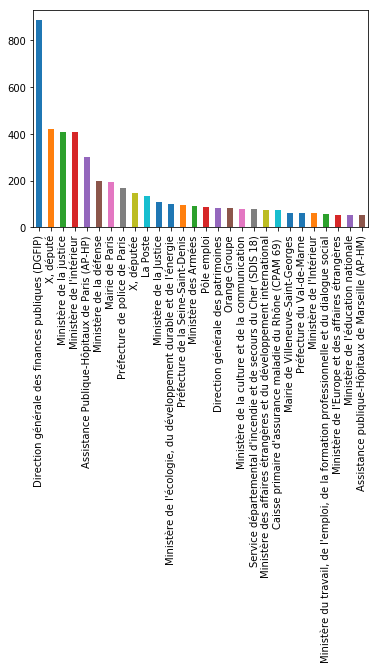

In [10]:
admin[admin >= 50].plot(kind="bar")
sup_50 = admin[admin >= 50].index

### Distribution of type of sense by year

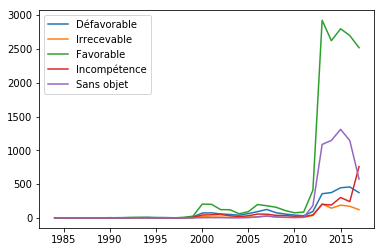

In [11]:
# df_sup_50 = df.loc[df["Administration"].isin(sup_50)]
# gp50 = df_sup_50.groupby(["Administration", "Sens_reduced"])
# gp50.plot(kind="bar")

from collections import defaultdict
annee_sens = defaultdict(dict)
types_sens = list(filter(None, df.Sens_reduced.dropna().unique().tolist()))
gp2 = df.groupby(["Année", "Sens_reduced"])
gp2.groups
for name, gp in gp2:
#     print(name)
#     print(gp)
    if name[1]:
        annee_sens[name[0]][name[1]] = len(gp)
df2 = pd.DataFrame.from_dict(annee_sens, orient="index").fillna(0)
df2.dropna().plot()
# df2
# annee_sens[2013]


### Treatment delay

The intuition is that given that there are two dates on the first sentence of the Avis. The first one is the date of the
séance and the second one is the date of the reception of the dossier at the CADA. Usually, the first date is the same
as the one in the column séance. The second date is the date of the demande. So it should be as easy as substracting the latter from the former. 
 
But not all avis have two dates, a lot have only one and it can be either the date of the seance of the resolution or the date the demande was received. The date of the seance is intuitively always preceded by the phrase "dans sa seance du". So the other date should be always the date of the demande's reception.

In [12]:
# Split lines of the avis
df["Avis_splitted"] = df["Avis"].dropna().apply(lambda x: x.split("\n"))

In [16]:
def get_avis_regex(text):
    """
    Get the date of the reception of the avis. There are around 3000 avis that do not contain a reception date
    or are this naive approach is not able to extract said date (among ~40k, which is okish)
    """
    secretariat_regex = r"\sson secrétariat\sle\s([0-9][0-9]?\s\w{3,}\s[0-9]{,4})"
    par_lettre_regex = r"\slettre\sdu\s([0-9][0-9]?\s\w{3,}\s[0-9]{,4})"
    match = re.findall(par_lettre_regex, text[0])
    match2 = re.findall(secretariat_regex, text[0])
    if match or match2:
        return dateparser.parse(match[0] if match else match2[0], languages=["fr"])
    else:
        return None

In [17]:
# giant_regex = r'(séance\sdu\s[0-9][0-9]?\s\w+\s[0-9]{,4})|([0-9][0-9]?\s\w+\s[0-9]{4})'
df["Avis_splitted"] = df["Avis"].dropna().apply(lambda x: x.split("\n"))

df["Avis_dates"] = df.loc[df["Type"]=="Avis"]["Avis_splitted"].dropna().apply(lambda x: get_avis_regex(x))

In [18]:
#  Transform seance date
df["Séance_date"] = df["Séance"].dropna().apply(lambda x: dateparser.parse(x, languages=["fr"]))

In [21]:
delta_dates = (df.Séance_date - df.Avis_dates).apply(lambda x: x.days)

In [23]:
delta_dates[delta_dates < 0] = np.NaN
df["delta_dates"] = delta_dates

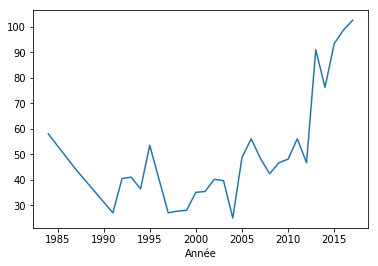

In [24]:
df.dropna().groupby(["Année", "delta_dates"], as_index=False).mean().groupby("Année")["delta_dates"].mean().plot()

In [15]:
pd.set_option('display.max_colwidth', 0)
df[["Type", "Avis", "Avis_dates"]].dropna()

,Type,Avis,Avis_dates
0,Avis,"La commission d'accès aux documents administratifs a examiné dans sa séance du 3 mars 1984 la demande dont vous l'avez saisie par lettre du 21 décembre 1983.\n\nLa commission a émis un avis défavorable à la communication du dossier d'enquête relatif au refus de votre admission en qualité d'élève-officier de réserve interprète et du chiffre de la Marine, au motif qu'elle porterait atteinte au secret de la défense nationale, exception prévue par l'article 6 de la loi du 17 juillet 1978.",1983-12-21
1,Avis,"La commission d'accès aux documents administratifs a examiné dans sa séance du 13 décembre 1984 la demande dont vous l'avez saisie par lettre du 31 octobre 1984.\n\nLa commission a estimé que la communication des analyses des rejets provenant du Centre d'Etude du Bouchet à Vert-le-Petit pourrait permettre la divulgation des activités du Centre et des procédures techniques employées et serait par là de nature à porter atteinte au secret de la défense nationale. Il en va de même des « plans de secours », qui sont indissociables des activités pratiquées au Centre.\n\nEn conséquence, et en application des dispositions de l'article 6 de le loi du 17 juillet 1978, la commission a rendu un avis défavorable sur ces deux points de votre demande.\n\nSur les autres points, celle-ci a été rejetée comme irrecevable ; elle est en effet formulée en termes trop généraux et constitue plus une demande de renseignement qu'une demande d'un document administratif précis.",1984-10-31
2,Avis,"La commission d'accès aux documents administratifs a examiné dans sa séance du 5 décembre 1985 la demande dont vous l'avez saisie par lettre du 5 novembre dernier et a formulé un avis dont le sens est défavorable à la communication du programme annuel de vérification fiscale et des critères sur le fondement desquels tel contribuable y est inclus. En effet, la communication de ce document administratif serait, aux termes de l'article 6 de la loi n° 78-753 du 17 juillet 1978, de nature à porter atteinte « à la recherche par les services compétents des infractions fiscales ».\n\nPar ailleurs, la commission a considéré que votre demande tendant à obtenir communication des documents de vérification fiscale concernant votre association était sans objet tant qu'ils ne sont pas achevés.",1978-07-17
4,Avis,"La commission d'accès aux documents administratifs a examiné dans sa séance du 2 avril 1987 la demande d'avis de Monsieur H. et a émis un avis favorable à la communication par vous-même à Monsieur H. de l'étude réalisée sur l'implantation des caisses de la Banque de France. La commission a d'ailleurs constaté que vous ne vous opposiez pas à la communication de ce document.\n\nLa commission a en revanche émis un avis défavorable à la partie de la demande de Monsieur H. qui concerne les deux rapports rédigés par l'Inspection de la Banque de France et qui ont pour objet les agressions commises contre les comptoirs de la Banque de France à Niort et à Saint-Nazaire. La commission a en effet estimé que la communication de ces documents serait de nature à porter atteinte à la sécurité publique, au sens de l'article 6 de la loi du 17 juillet 1978.\n\nEn ce qui concerne le rapport d'audit réalisé par la Banque de France sur sa direction du crédit, la commission a émis un avis favorable à la communication de ce document sous deux réserves :\n\n- les paragraphes 3.1 et 3.3 du rapport doivent être occultés dès lors qu'ils contiennent des informations de nature nominative au sens de la loi du 17 juillet 1978 ;\n\n- les paragraphes 2.1.3 et 4 du rapport ne sont communicables qu'à l'expiration du délai permettant au gouverneur de la Banque de France de donner les suites qui conviennent aux propositions qui y sont contenues.\n\nEn ce qui concerne enfin le rapport d'audit réalisé par la Banque de France sur sa centrale de bilans, la commission a émis un avis favorable à la communication de ce document sous la réserve que les paragraphes 3 et 4 de ce rapp